# PDE SOLVER USING NEURAL NETWORK

In [139]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')


In [140]:
x = torch.cuda.current_device()
x

0

In [141]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

We consider boundary value problems with Dirichlet and Neumann BCs. 

All subsequent problems were defined on the domain [0, 1] × [0, 1] and in order to perform training 

we consider a mesh of 100 points obtained by considering 10 equidistant points of the domain [0, 1] 
of each variable. 

The neural architecture is MLP with two inputs (accepting the coordinates 
x and y of each point), 

10 sigmoid hidden units and one linear output
unit.

In [142]:
x = torch.linspace(0, 1, 10).unsqueeze(1).to(device=device)
x

tensor([[0.0000],
        [0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]], device='cuda:0')

In [143]:
y = torch.linspace(0, 1, 10).unsqueeze(1).to(device=device)
y.shape

torch.Size([10, 1])

In [144]:
x_mesh, y_mesh = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
print(x_mesh.shape)
print(y_mesh.shape)


torch.Size([10, 10])
torch.Size([10, 10])


In [145]:
X_flat = x_mesh.reshape(-1,1)
Y_flat = y_mesh.reshape(-1,1)

In [146]:
Z = torch.cat((X_flat, Y_flat), dim=1)
print(Z.shape)
print(Z[0:10])

torch.Size([100, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.1111],
        [0.0000, 0.2222],
        [0.0000, 0.3333],
        [0.0000, 0.4444],
        [0.0000, 0.5556],
        [0.0000, 0.6667],
        [0.0000, 0.7778],
        [0.0000, 0.8889],
        [0.0000, 1.0000]], device='cuda:0')


In [147]:
ones = torch.ones(x.shape[0], x.shape[1]).to(device=device)
ones_2 = torch.ones_like(x)
print(ones)
print(ones.shape)
print(ones_2)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')
torch.Size([10, 1])
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0')


In [148]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.Hidden_layer = nn.Linear(in_features=2,out_features=10)
        self.Output_layer = nn.Linear(in_features=10,out_features=1,bias=False)
        self.Sigmoid = nn.Sigmoid()

    def forward(self,x,y):
        inputs = torch.cat((x, y), dim=1)
        return self.Output_layer(self.Sigmoid(self.Hidden_layer(inputs)))

In [149]:
NeuralNetwork()

NeuralNetwork(
  (Hidden_layer): Linear(in_features=2, out_features=10, bias=True)
  (Output_layer): Linear(in_features=10, out_features=1, bias=False)
  (Sigmoid): Sigmoid()
)

## Example Problme 1


PDE: 

\begin{equation}
    \nabla^2 u(x,y) = e^{-x}(x - 2 + y^3 + 6y)
\end{equation}

Let

\begin{equation}
    f(x,y):=  e^{-x}(x - 2 + y^3 + 6y)
\end{equation}

Dirichlet BCs : 

\begin{equation}
    \begin{cases}
        u(0,y) = y^3 \\
        u(1,y) = (1 + y^3)e^{-1} \\
        u(x,0) = xe^{-x} \\
        u(x,1) = e^{-x}(x + 1)
    \end{cases}
\end{equation}

\begin{equation}
    x,y \in [0,1]
\end{equation}

Analytical solution of above ODE is:

\begin{equation}
    u_a(x,y) = e^{-x}(x + y^3)
\end{equation}

Trail solution is of the form:

\begin{equation}
    u(x,y)_t = A(x,y) + x(1-x)y(1-y)N(x,y,p) 
\end{equation}

where,

\begin{equation}
    A(x,y) = (1-x)y^3 + x(1+y^3)e^{-1} + (1-y)x(e^{-x}-e^{-1}) + y[(1+x)e^{-x} - (1 - x + 2xe^{-1})]
\end{equation}


In [150]:
# For Example Problem 1 Only

def f(x,y):
    return  torch.exp(-x) * (x - 2.0 + y**3.0 + 6.0*y)

def A(x,y):
    minus_one = -torch.ones_like(x)

    return (1.0 - x) * (y**3.0) + x * (1.0 + y**3.0) * torch.exp(minus_one) + (1.0 - y) * x * (torch.exp(-x) - 
            torch.exp(minus_one)) + y * ((1.0 + x) * torch.exp(-x) - ( 1.0 - x + 2.0 * x * torch.exp(minus_one)))

def u_exact(x,y):
    return torch.exp(-x) * ( x + y**3.0)

def u_trail(x,y,N):
    return A(x,y) + x * (1.0 - x) * y * (1.0 - y) * N(x,y)

def loss_1(x,y,N):
    x.requires_grad = True
    y.requires_grad = True
    u = u_trail(x,y,N)

    # Compute first-order derivatives
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x),create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y,grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Compute second-order derivatives (Laplacian terms)
    d2u_dx2 = torch.autograd.grad(du_dx, x,grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y,grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Compute the Laplacian (sum of second-order derivatives)
    grad_2 = d2u_dx2 + d2u_dy2
    G = (grad_2 - f(x,y))**2.0
    
    return torch.sum(G)

In [151]:
def Optimize(x,y,epochs,N):

    optimizer = torch.optim.LBFGS(N.parameters())
    
    def train():
        optimizer.zero_grad()
        l = loss_1(x,y,N)
        l.backward()

        return l

    for _ in tqdm(range(epochs)):
        optimizer.step(train)

In [152]:
def Plot_solutions(X, Y, N):
    
    u_pred = u_trail(X, Y, N)

    U_exact = u_exact(X, Y).reshape(10, 10).detach().cpu().numpy()
    x = X.reshape(10, 10).detach().cpu().numpy()
    y = Y.reshape(10, 10).detach().cpu().numpy()
    u_pred = u_pred.reshape(10, 10).detach().cpu().numpy()

    # Create a figure with 2 subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})
    
    # --- Subplot 1: Exact Solution ---
    ax1.plot_surface(x, y, U_exact, cmap='viridis', edgecolor='none')
    ax1.set_title('Exact Solution')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('U_exact')
    ax1.set_yticks(np.linspace(np.min(y), np.max(y), num=3))
    ax1.set_xticks(np.linspace(np.min(x), np.max(x), num=3))
    ax1.set_zticks(np.linspace(np.min(U_exact), np.max(U_exact), num=5))
    ax1.set_box_aspect(None, zoom=0.85)  # Adjust the aspect ratio

    # --- Subplot 2: Deviation Plot (Predicted - Exact) ---
    deviation = u_pred - U_exact
    z_min = np.min(deviation)
    z_max = np.max(deviation)

    ax2.plot_wireframe(x, y, deviation)
    ax2.set_title('Deviation (Predicted - Exact)')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Deviation', labelpad=10)
    ax2.set_zlim(z_min, z_max)
    ax2.set_yticks(np.linspace(np.min(y), np.max(y), num=5))
    ax2.set_xticks(np.linspace(np.min(x), np.max(x), num=5))
    ax2.set_zticks(np.linspace(z_min, z_max, num=5))

    # Rotate z-axis labels for better fit
    ax2.zaxis.set_rotate_label(False)
    ax2.set_zlabel('Deviation', rotation=90)
    ax2.set_box_aspect(None, zoom=0.85)  # Adjust the aspect ratio
    ax2.view_init(elev=30, azim=120)

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [ ]:
def MSE_Calculate(xx,yy,N):

    uu_pred = u_trail(xx, yy, N)
    uu_exact = u_exact(xx,yy)
        
    mse = torch.mean((uu_pred - uu_exact)**2)
    print(f"MSE: {mse}")

In [154]:
EPOCHS = 15

100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


torch.Size([100, 1]) torch.Size([100, 1])
MSE: 1.876385765514632e-12


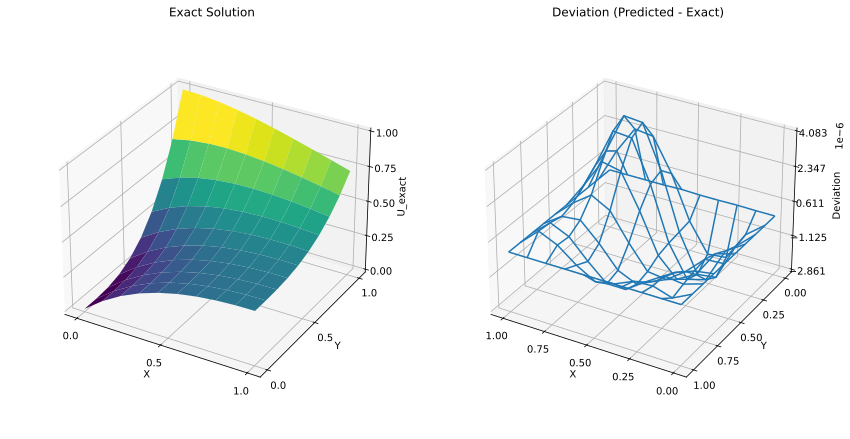

In [155]:
# Example Problem 1 Solution

X = torch.linspace(start=0,end=1,steps=10).unsqueeze(1).to(device=device)
Y = torch.linspace(start=0,end=1,steps=10).unsqueeze(1).to(device=device)
x_mesh,y_mesh = torch.meshgrid(X.squeeze(),Y.squeeze(),indexing='ij')
X_flat = x_mesh.reshape(-1,1)
Y_flat = y_mesh.reshape(-1,1)
N = NeuralNetwork().to(device=device)

Optimize(X_flat,Y_flat,EPOCHS,N)
MSE_Calculate(X_flat,Y_flat,N)
Plot_solutions(X_flat,Y_flat,N)

## Example Problem 2

### PDE:

\begin{equation}
\nabla^2 u(x, y) = (2-\pi^2y^2)sin(\pi x)
\end{equation}

Let

\begin{equation}
    f(x,y):=  (2-\pi^2y^2)sin(\pi x)
\end{equation}


### Dirichlet BCs: 

\begin{align}
u(0, y) &= 0 \\
u(1, y) &= 0 \\
u(x, 0) &= 0 \\
\frac{\partial u}{\partial y}(x, 1) &= 2 \sin(\pi x)
\end{align}

\begin{equation}
    x, y \in [0,1]
\end{equation}

### Analytical Solution:

The analytical solution of the above PDE is:

\begin{equation}
u_a(x, y) = y^2sin(\pi x)
\end{equation}

### Trial Solution:

The trial solution is of the form:

\begin{equation}
u_t(x, y) = A(x, y) + x(1 - x) y \left[ N(x, y, \mathbf{p}) - N(x, 1, \mathbf{p}) - \frac{\partial N(x, 1, \mathbf{p})}{\partial y} \right]
\end{equation}

where,

\begin{equation}
    A(x, y) =  2y \sin(\pi x) 
\end{equation}


In [156]:
# For Example Problem 2 Only

def f(x,y):
    return  (2 - torch.pi ** 2 * y**2) * torch.sin(torch.pi * x)

def A(x,y):
    return 2 * y * torch.sin(torch.pi * x)

def u_exact(x,y):
    return y**2 * torch.sin(torch.pi * x)

def u_trail(x, y, N):
    x.requires_grad = True
    y.requires_grad = True
    n = N(x, torch.ones_like(y))
    dn_dy = torch.autograd.grad(n.sum(), y, create_graph=True, allow_unused=True)[0] 
    return A(x, y) + x * (1 - x) * y * (N(x, y) - n - (dn_dy if dn_dy is not None else 0))


def loss_1(x,y,N):
    x.requires_grad = True
    y.requires_grad = True
    u = u_trail(x,y,N)

    # Compute first-order derivatives
    du_dx = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(x), create_graph=True)[0]
    du_dy = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Compute second-order derivatives (Laplacian terms)
    d2u_dx2 = torch.autograd.grad(du_dx, x,grad_outputs=torch.ones_like(x), create_graph=True)[0]
    d2u_dy2 = torch.autograd.grad(du_dy, y,grad_outputs=torch.ones_like(y), create_graph=True)[0]

    # Compute the Laplacian (sum of second-order derivatives)
    grad_2 = d2u_dx2 + d2u_dy2
    G = (grad_2 - f(x,y))**2
    
    return torch.sum(G)

100%|██████████| 15/15 [00:17<00:00,  1.18s/it]


torch.Size([100, 1]) torch.Size([100, 1])
MSE: nan


ValueError: Axis limits cannot be NaN or Inf

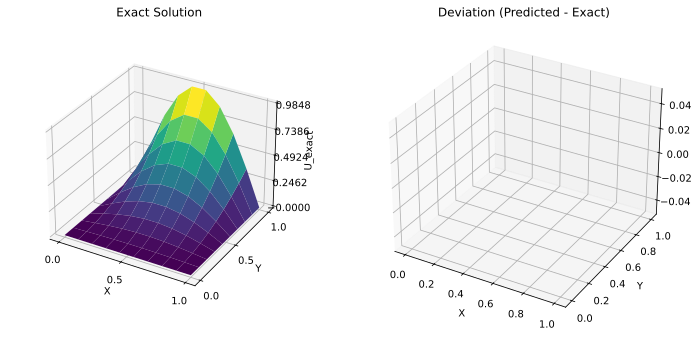

In [158]:
# Example Problem 2 Solution

X = torch.linspace(start=0,end=1,steps=10).unsqueeze(1).to(device=device)
Y = torch.linspace(start=0,end=1,steps=10).unsqueeze(1).to(device=device)
x_mesh,y_mesh = torch.meshgrid(X.squeeze(),Y.squeeze(),indexing='ij')
X_flat = x_mesh.reshape(-1,1)
Y_flat = y_mesh.reshape(-1,1)
N = NeuralNetwork().to(device=device)

Optimize(X_flat,Y_flat,EPOCHS,N)
MSE_Calculate(X_flat,Y_flat,N)
Plot_solutions(X_flat,Y_flat,N)